In [1]:
import generate_visual_bars_data as vbd

from cluster_methods import kmeans
from density_estimation_methods import condExp
import tensorflow as tf
import numpy as np 

import core_cfl_objects.two_step_cfl as tscfl

In [2]:
# generate visual bars data 
n_samples = 1000
im_shape = (10, 10)
vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=0)

x = vb_data.getImages()
print(x[0:10])
y = vb_data.getTarget()
print(y[0:10])


#reformat x, y into the right shape for the neural net 
y = np.expand_dims(y, -1)
x = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2])) 


[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0

In [3]:
# parameters for CDE 
optimizer_Adam = tf.keras.optimizers.Adam(lr=1e-3)
condExp_params = {'batch_size': 128, 'lr': 1e-3, 'optimizer': optimizer_Adam, 'n_epochs': 200, 'test_every': 10, 'save_every': 10}
data_info = {'X_dims': x.shape, 'Y_dims': y.shape} #NOTE: I was a little confused here about how to enter the dimensions until I realized to just get the shape from the np function 
print(data_info)

# generate CDE object
condExp_object = condExp.CondExp(data_info, condExp_params, True)



{'X_dims': (1000, 100), 'Y_dims': (1000, 1)}


In [4]:
# generate clusterer 
cluster_params = {'n_Xclusters':4, 'n_Yclusters':4}
cluster_object = kmeans.KMeans(cluster_params)


# put into a cfl core object 
cfl_object = tscfl.Two_Step_CFL_Core(condExp_object, cluster_object)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nn_input_layer (InputLayer)  [(None, 100)]             0         
_________________________________________________________________
nn_dropout1 (Dropout)        (None, 100)               0         
_________________________________________________________________
nn_dense1 (Dense)            (None, 50)                5050      
_________________________________________________________________
nn_dropout2 (Dropout)        (None, 50)                0         
_________________________________________________________________
nn_layer2 (Dense)            (None, 10)                510       
_________________________________________________________________
nn_dropout3 (Dropout)        (None, 10)                0         
_________________________________________________________________
nn_output_layer (Dense)      (None, 1)                 11    

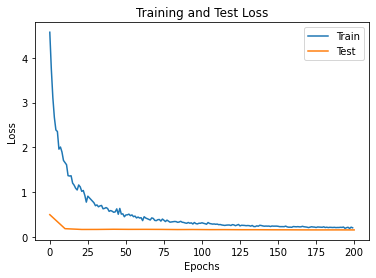

100%|██████████| 1000/1000 [00:00<00:00, 3674.68it/s]


In [5]:
x_lbls, y_lbls = cfl_object.train(x, y)

# and then run visual bars through that 
# see what we get 

In [23]:
# check the results of CFL against the original 
truth=vb_data.getGroundTruth().astype(int)
print(truth[0:20])
print(x_lbls[0:20])
print(np.sum(x_lbls==0), np.sum(x_lbls==1), np.sum(x_lbls==2), np.sum(x_lbls==3))
print(np.sum(truth==0), np.sum(truth==1), np.sum(truth==2), np.sum(truth==3))
accuracy1 = (x_lbls == vb_data.getGroundTruth())



def correspond(ground_truth, x_lbls, length_head):
    gtHead = ground_truth[0:length_head]
    xHead = x_lbls[0:length_head]
    print("gtHead is, ", gtHead)
    print("xHeaf is", xHead)
    answers = {}
    for gt_label in [0, 1, 2, 3]: 
        print("current label:" , gt_label)
        # find the classes that correspond to the current ground truth label 
        currentClasses = np.asarray(gtHead==gt_label).nonzero()
        # figure out, of these, which class label in xHead is most common 
        print(currentClasses)
        options = [np.count_nonzero(xHead[currentClasses]==0), np.count_nonzero(xHead[currentClasses]==1), np.count_nonzero(xHead[currentClasses]==2), np.count_nonzero(xHead[currentClasses]==3)]
        print("options are:, ", options)
        answers[str(gt_label)] = np.argmax(options)
        print("added, for gt_label", gt_label, "discovered label", np.argmax(options))
    return answers 

print(correspond(truth, x_lbls, 10))

print("percent correct: ", np.sum(accuracy)/len(accuracy))

[2 0 0 0 2 1 3 1 1 0 1 3 1 2 1 3 1 3 2 2]
[0 2 2 2 3 0 3 3 0 2 0 1 0 3 0 1 3 1 0 3]
252 247 248 253
248 240 251 261
gtHead is,  [2 0 0 0 2 1 3 1 1 0]
xHeaf is [0 2 2 2 3 0 3 3 0 2]
current label: 0
(array([1, 2, 3, 9], dtype=int64),)
options are:,  [0, 0, 4, 0]
added, for gt_label 0
current label: 1
(array([5, 7, 8], dtype=int64),)
options are:,  [2, 0, 0, 1]
added, for gt_label 1
current label: 2
(array([0, 4], dtype=int64),)
options are:,  [1, 0, 0, 1]
added, for gt_label 2
current label: 3
(array([6], dtype=int64),)
options are:,  [0, 0, 0, 1]
added, for gt_label 3
{'0': 2, '1': 0, '2': 0, '3': 3}
percent correct:  0.014


In [7]:
# thoughts: 
# - currently, we have to reshape x and y to get them into the right shape for the neural net, which is annoying
# - it gave y-labels, which we didn't want (they're kind of meaningless in this case? raise a warning to prevent people from doing? )
# - I think we should raise a warning or something if the CDE gets trained twice - cause otherwise you could get confusing graphs from the training/test loss
# the tqdm bar is great, but you can't tell it's referring to the clustering - we should add a print statement ahead of it 
# the import statements are kind of slow - are we double importing stuff? is there are reason they're slow? slash - eventually - we want to be able to just import everything all with one import statement, right? "import cfl" or something
# add set_seed to visual bars so that it's repeatable 